## Why the diagnosed incoherence timescales seem wrong? Can it be linked to the filter form?

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

dt = 1/24

omega_sn = (omega_S2-omega_M2)/2
#tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag
print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')



Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [3]:
root_dir = '/Users/zcaspar/codes/mit4320/'

In [4]:
ds = xr.open_dataset(root_dir+'cov_total_bins.nc')

ds

In [6]:
_ = ds.MS_real_real.sel(signal='incoherent',T=5).mean('draw_bins')

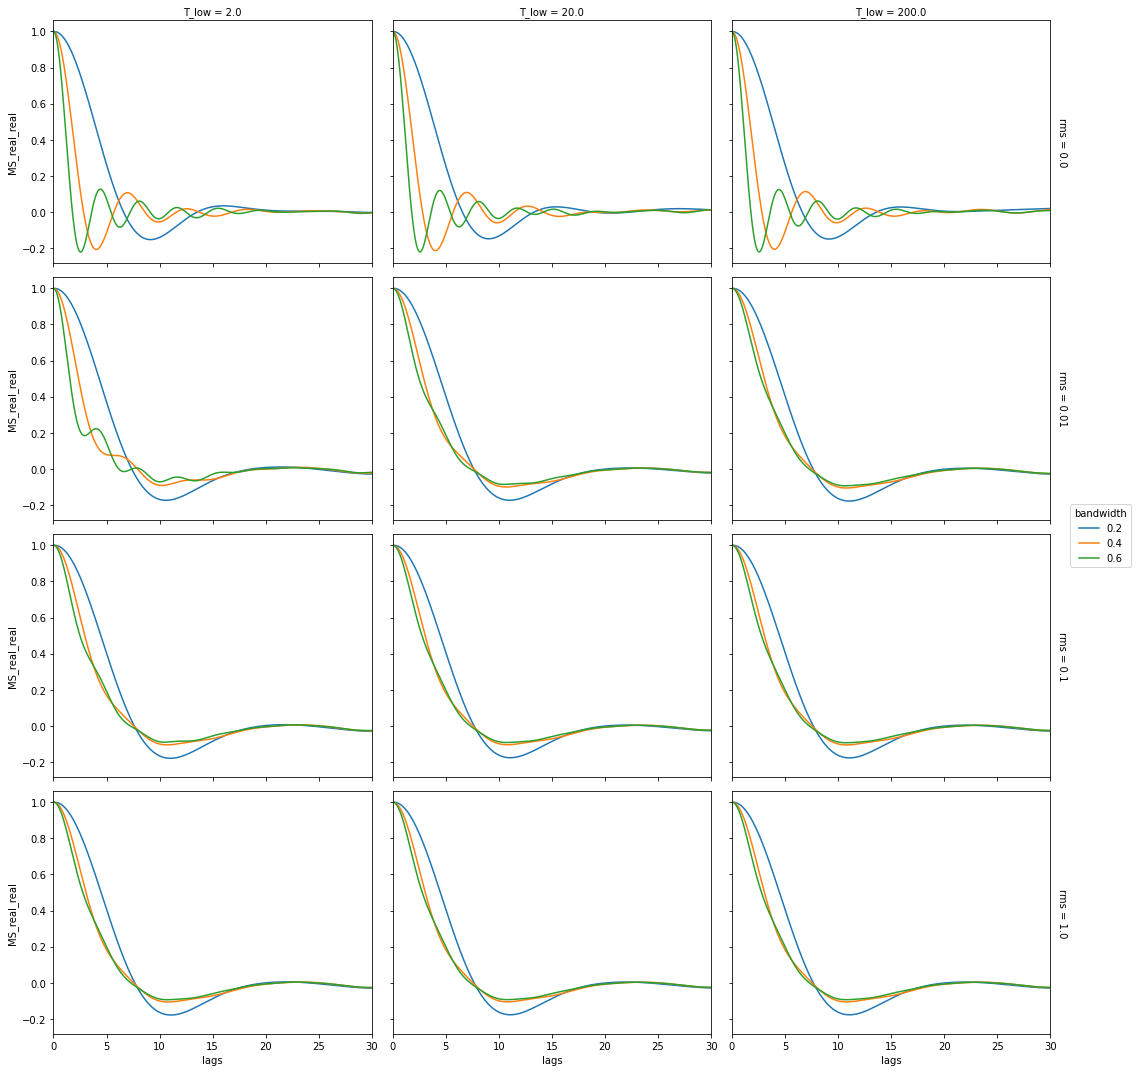

In [7]:
ax = (_/_.isel(lags=0)).plot(col='T_low',row='rms',hue='bandwidth',figsize=(15,15),xlim=(0,30))

#### Notes:
For high contamination of the semidiurnal band by low frequency motion (i.e. short decorrelation timescales and low ratio high/low energy ratio), fast oscillations are observed.
There seem to be a link between these oscillations frequency and the filter bandwidth.

### Investigating the autocovariance of the response of a band pass filter


In [78]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)+1   
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

In [79]:
import scipy.signal as signal
dband = [0.1,0.2,0.3] #0.05,
dt = 1/24
Tw = 30
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

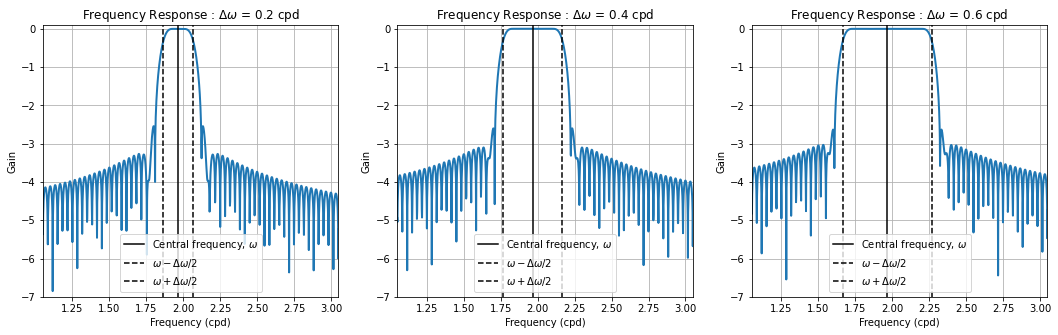

In [80]:
fig,axs = plt.subplots(1,len(h.keys()),figsize=(6*len(h.keys()),5))
for ax,filt in zip(axs,h.keys()):
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(omega, color='k',label=r'Central frequency, $\omega$')
    ax.axvline(omega-float(filt),linestyle='--', color='k',label=r'$\omega-\Delta\omega/2$')
    ax.axvline(omega+float(filt),linestyle='--', color='k',label=r'$\omega+\Delta\omega/2$')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title(r'Frequency Response : $\Delta\omega$ = %s cpd'% str(2*float(filt)))
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(1.05, 3.05)
    ax.grid(True)
    ax.legend()

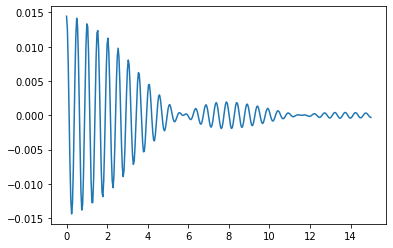

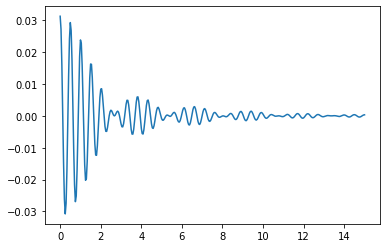

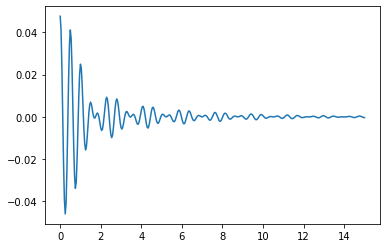

In [84]:
for filt in h.keys():
    plt.figure()
    plt.plot(np.arange(0,15+dt,dt),signal.correlate(h[filt],h[filt],mode='same')[np.arange(0,15,dt).size:])

In [61]:
signal.correlate(h[filt],h[filt],mode='same').size

720

In [85]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [86]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

In [87]:
def generate_timeseries(delta_T, n_draws, T, sigma0, filtering=True, seed=0, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=seed,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    if filtering:
        ds["u_bar"] = sigp.filt(ds.u, filter_h)    
    return ds

In [88]:
delta_T = 300 # time series length in days
n_draws = 5 # number of draws
#T_all = [0.1*T, 0.5*T, T,  2*T]
T_all = [0.5*T, T, 2*T, 4*T]
rad = 2*np.pi

In [ ]:
file_lf = root_dir+'ds_synthetic_lf.nc'
ds_low = xr.open_dataset(file_lf)#.persist()
#ds_hf = xr.open_dataset(root_dir+'ds_synthetic_hf.nc').persist()

ds_low = ds_low.sel(draw=slice(0,n_draws-1))
ds_low = ds_low.isel(filt=1).rename({'T':'T_low'})
ds_low

In [ ]:
i = 3#,2
ds_hf = {}
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf_real = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
#    ds_hf_imag = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=j)
#    ds_hf[c] = ((ds_hf_real+1j*ds_hf_imag)/np.sqrt(2)*np.exp(1j*om*rad*ds_hf_real['u'].time)).u
    ds_hf[c] = ds_hf_real*np.exp(1j*om*rad*ds_hf_real['u'].time)
    #ds_hf[c] = ds_hf[c].chunk({'time':-1,'draw':-1,'T':-1})
    i+=1
#    j+=2
ds_hf

In [92]:
test = xr.open_zarr(root_dir+'ds_synthetic_total.zarr').compute()

In [94]:
sigp.bpass_demodulate(test.MS,omega,0.2,30)

In [95]:
def bpass_filter(
    omega,
    hbandwidth,
    numtaps,
    dt,
    ftype,
):
    """Wrapper around scipy.signal.firwing
    Parameters:
    -----------
    omega: float
        central frequency, units need to be cycle per time units
    hbandwidth: float
        half bandwidth, units need to be cycle per time units
    numptaps: int
        window size in number of points
    dt: float
        sampling interval
    ftype: str
        filter type
    """
    #
    if ftype == "firwin":
        h = signal.firwin(
            numtaps,
            cutoff=[omega - hbandwidth, omega + hbandwidth],
            pass_zero=False,
            fs=1.0 / dt,
            scale=True,
        )
    elif ftype == "firwin2":
        h = signal.firwin2(
            numtaps,
            [
                0,
                omega - hbandwidth,
                omega - hbandwidth * 0.5,
                omega + hbandwidth * 0.5,
                omega + hbandwidth,
                1.0 / 2 / dt,
            ],
            [0, 0, 1, 1, 0, 0],
            fs=1.0 / dt,
        )
    #
    t = np.arange(numtaps) * dt
    return h, t


def filter_response(h, dt):
    """Returns the frequency response"""
    w, h_hat = signal.freqz(h, worN=8000, fs=1 / dt)
    # return h_hat, (w/np.pi)/2/dt
    return h_hat, w


def convolve(x, h=None, hilbert=False):
    """Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    # x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f


def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    # gufunc_kwargs = dict(output_sizes={d: v[d].size for d in v.dims},
    #                     #output_sizes={'time': len(v.time)},
    #                     #meta=v,
    #                     )
    return xr.apply_ufunc(
        convolve,
        v,
        kwargs={"h": h, "hilbert": hilbert},
        dask="parallelized",
        output_dtypes=[output_dtype],
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        # dask_gufunc_kwargs = gufunc_kwargs,
    )


def bpass_demodulate(ds, omega, hbandwidth, T, ftype="firwin"):
    """create filter, filter time series, hilbert transform, demodulate
    ds: xr.DataArray
        input time series, "time" should be the time dimension
    omega: float
        central frequency, units need to be cycle per time units
    hbandwidth: float
        half bandwidth, units need to be cycle per time units
    T: float
        Window length in ds["time"] units
    """
    dt = float(ds["time"][1] - ds["time"][0])

    h, t = bpass_filter(omega, hbandwidth, int(T / dt), dt, ftype)
    h_hat, w = filter_response(h, dt)

    exp = np.exp(-1j * 2 * np.pi * omega * ds["time"])
    for v in ds:
        ds[v + "_bpassed"] = filt(ds[v], h, hilbert=True).persist()
        ds[v + "_demodulated"] = ds[v + "_bpassed"] * exp
    ds["exp"] = exp

    return ds, h, h_hat, w


In [96]:
test = xr.open_dataset(root_dir+'ds_synthetic_lf.nc')

In [97]:
test

<xarray.Dataset>
Dimensions:  (T: 3, time: 7200, draw: 500, filt: 3)
Coordinates:
  * T        (T) float64 2.0 20.0 200.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * filt     (filt) int64 0 1 2
Data variables:
    u        (filt, T, time, draw) float64 ...
    u_bar    (filt, T, draw, time) float64 ...

In [125]:
_test = test.sel(filt=1).mean('draw').rename({'T':'T_low'})


In [126]:
demodulated, h, h_hat, w = bpass_demodulate(_test,omega,0.2,30)

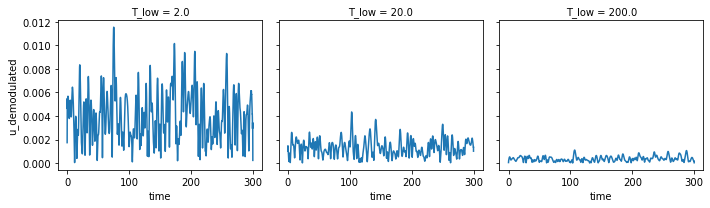

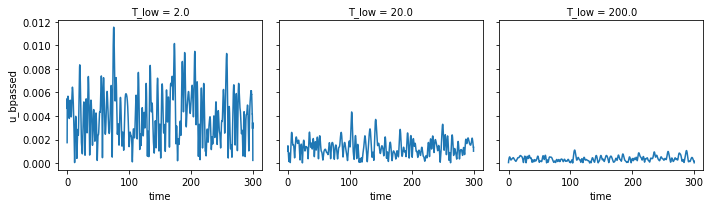

In [136]:
np.abs(demodulated.u_demodulated).plot(col='T_low')
np.abs(demodulated.u_bpassed).plot(col='T_low')

In [137]:
correlated = sigp.correlate(np.abs(demodulated.u_demodulated),np.abs(demodulated.u_demodulated)).compute()

ValueError: replacement data must match the Variable's shape. replacement data has shape (3, 0); Variable has shape (3, 7200)